In [1]:
import warnings
import xarray as xr
from matplotlib import pyplot as plt
from pywk99.spectrum import get_power_spectrum, get_background_spectrum
from pywk99.spectrum import plot_spectrum_peaks
from pywk99.timeseries import remove_seasonal_cycle
from pywk99.timeseries import remove_linear_trend
from pywk99.filter import get_tropical_depression_window, get_box_filter_window
from pywk99.filter import filter_variable
from pywk99.filter import plot_filter_window

In [2]:
# run data/download.ipynb to download the example data
season = "JJA"
ds = xr.open_dataset("data/olr.2xdaily.1979-2022.nc")
variable = ds.olr.sel(lat=slice(20, -20, None), time=slice("1979", "1996"))
variable = variable.resample({"time": "1D"}).mean()
variable = variable.sortby("lat")

In [3]:
warnings.filterwarnings("ignore", message="Converting non-nanosecond precision timedelta values to nanosecond precision")
variable_normalized = remove_linear_trend(variable)
variable_normalized = remove_seasonal_cycle(variable)

In [4]:
symmetric_spectrum = get_power_spectrum(variable_normalized, "symmetric")
asymmetric_spectrum = get_power_spectrum(variable_normalized, "asymmetric")
background_spectrum = get_background_spectrum(symmetric_spectrum, asymmetric_spectrum)
symmetric_spectrum_season = get_power_spectrum(variable_normalized, "symmetric", season=season)
asymmetric_spectrum_season = get_power_spectrum(variable_normalized, "asymmetric", season=season)

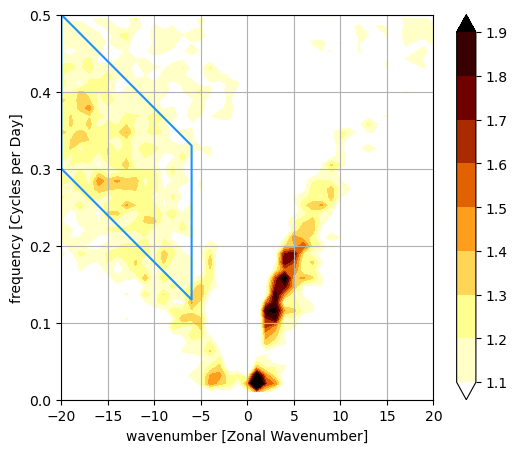

In [5]:
# Define regions with spectrum artifacts
flagged_window1 = get_box_filter_window(13.5, 14.5, 0.08, 0.15)
flagged_window2 = get_box_filter_window(13.5, 14.5, 0.18, 0.25)
flagged_window3 = get_box_filter_window(-14.5, -5, 0.75, 1)
flagged_windows = flagged_window1.union(flagged_window2).union(flagged_window3)

fig, ax1 = plt.subplots(1 , 1, figsize=(6, 5))
plot_spectrum_peaks(symmetric_spectrum_season, background_spectrum, ax1,
                    flagged_windows=flagged_windows,
                    k_max=20, k_min=-20,
                    w_max=0.5)
tropical_depression_window = get_tropical_depression_window()
plot_filter_window(tropical_depression_window, ax=ax1)
plt.grid()

In [6]:
filtered_variable = filter_variable(variable, tropical_depression_window)
filtered_variable = filtered_variable.where(filtered_variable.time.dt.season == season, drop=True)

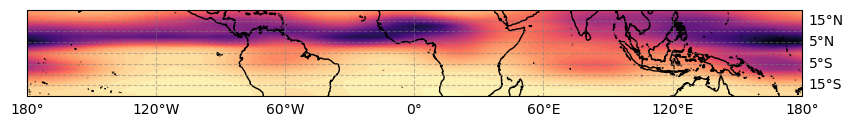

In [7]:
# plot the variance associated with the tropical depression window for JJA
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

fig = plt.figure(figsize=(10,5))
ax = plt.subplot(projection=ccrs.PlateCarree())
ax.coastlines()
gridlines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                         color='gray', alpha=0.5, linestyle='--')
gridlines.top_labels = False
gridlines.left_labels = False
lon = filtered_variable.lon.values
lat = filtered_variable.lat.values
values = filtered_variable.tropical_depression.var("time").values.T
cyclic_data, cyclic_lons = add_cyclic_point(values, coord=lon)
cf = ax.contourf(cyclic_lons, lat, cyclic_data, 55, cmap="magma_r")